In [1]:
import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


seed_ = 20200218
np.random.seed(seed_)

import tensorflow as tf
tf.random.set_seed(seed_)

from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", 
              context="paper", 
              font='Dank Mono', 
              font_scale=1.25, 
              rc={"figure.figsize": (10.5, 4.5), "figure.dpi": 150, "grid.alpha": 0.5}
             )
_30k = ["#202f66", "#ff7048", "#7f68d0", "#f3d36e", "#d869ab", "#1b262c"]
sns.set_palette(_30k)

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

pio.templates.default = "plotly_dark"

import wordcloud

import warnings
warnings.filterwarnings('ignore')

# Introduction to Word2Vec

ทำตาม บทความ 

https://blog.pjjop.org/word2vec-model-for-kincentric/

## The dataset

my favorite song lyric, ashes from sawano hiroyuki

In [3]:
with open("./data/sawano-ashes.txt", "r", encoding="utf-8") as f:
    texts = [text.strip("\n") for text in f.readlines() if text.strip("\n") != '']

In [4]:
texts

['I could hear the signs calling out from the bottom of the fire',
 'I am like a torch flickering in the wind as the saying goes',
 'Lost all my precious',
 'Rage ate me up',
 'Endless forlornness has made me numb',
 "I'd rather rise from here",
 'Or should I hold on to my past?',
 "They've burnt to ashes",
 'Faded to grey',
 'Returned to the earth',
 "Yes it's meant to be",
 'Uncertain flame of hope I found',
 'Will you lead me back on the right track?']

## สร้าง vocab

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

word_index = tokenizer.word_index
index_word = {i: w for w, i in word_index.items()}
word_index

{'the': 1,
 'to': 2,
 'i': 3,
 'me': 4,
 'from': 5,
 'of': 6,
 'my': 7,
 'on': 8,
 'could': 9,
 'hear': 10,
 'signs': 11,
 'calling': 12,
 'out': 13,
 'bottom': 14,
 'fire': 15,
 'am': 16,
 'like': 17,
 'a': 18,
 'torch': 19,
 'flickering': 20,
 'in': 21,
 'wind': 22,
 'as': 23,
 'saying': 24,
 'goes': 25,
 'lost': 26,
 'all': 27,
 'precious': 28,
 'rage': 29,
 'ate': 30,
 'up': 31,
 'endless': 32,
 'forlornness': 33,
 'has': 34,
 'made': 35,
 'numb': 36,
 "i'd": 37,
 'rather': 38,
 'rise': 39,
 'here': 40,
 'or': 41,
 'should': 42,
 'hold': 43,
 'past': 44,
 "they've": 45,
 'burnt': 46,
 'ashes': 47,
 'faded': 48,
 'grey': 49,
 'returned': 50,
 'earth': 51,
 'yes': 52,
 "it's": 53,
 'meant': 54,
 'be': 55,
 'uncertain': 56,
 'flame': 57,
 'hope': 58,
 'found': 59,
 'will': 60,
 'you': 61,
 'lead': 62,
 'back': 63,
 'right': 64,
 'track': 65}

In [6]:
vocab_size = len(word_index)
vocab_size

65

In [7]:
sequnces = tokenizer.texts_to_sequences(texts)
sequnces

[[3, 9, 10, 1, 11, 12, 13, 5, 1, 14, 6, 1, 15],
 [3, 16, 17, 18, 19, 20, 21, 1, 22, 23, 1, 24, 25],
 [26, 27, 7, 28],
 [29, 30, 4, 31],
 [32, 33, 34, 35, 4, 36],
 [37, 38, 39, 5, 40],
 [41, 42, 3, 43, 8, 2, 7, 44],
 [45, 46, 2, 47],
 [48, 2, 49],
 [50, 2, 1, 51],
 [52, 53, 54, 2, 55],
 [56, 57, 6, 58, 3, 59],
 [60, 61, 62, 4, 63, 8, 1, 64, 65]]

# Skip gram

สร้าง window ขนาด `window_size` ครอบพื้นที่ก่อน/หลังคำ (รวมคำตัวเอง)


```txt
window = 3
[2, 1, w], [w, 1, 2]
```

In [8]:
window_size = 3

In [9]:
data = []

for seq in sequnces:
    # current word index
    for i in range(len(seq)):
        # pairing current word and another nearby word in window range
        for near_word_index in range(
            max(i-window_size, 0), min(len(seq), i+window_size)
        ):
            if near_word_index != i:
                data.append([seq[i], seq[near_word_index]])
            

In [10]:
data[:10]

[[3, 9],
 [3, 10],
 [9, 3],
 [9, 10],
 [9, 1],
 [10, 3],
 [10, 9],
 [10, 1],
 [10, 11],
 [1, 3]]

# Encode Data

In [11]:
def one_hot(ind, vocab_size):
    one_hot_encoded = np.zeros(vocab_size)
    one_hot_encoded[ind-1] = 1
    return one_hot_encoded

def one_hot_to_word_index(onehot):
    return np.argmax(onehot) + 1

In [12]:
x_train = []
y_train = []

for pair in data:
    x_train.append(one_hot(pair[0], vocab_size))
    y_train.append(one_hot(pair[1], vocab_size))    

In [13]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [14]:
x_train.shape, y_train.shape

((303, 65), (303, 65))

In [15]:
x_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

# Model

In [16]:
embedding_dims = 8

In [17]:
model = tf.keras.models.Sequential()

# 2 hidden layers nn: 1.encoder  - 2. output
model.add(tf.keras.layers.Dense(embedding_dims, activation='relu', input_shape=(vocab_size,)))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(vocab_size, activation='softmax'))

In [18]:
optimizer = tf.keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 528       
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 65)                585       
Total params: 1,113
Trainable params: 1,113
Non-trainable params: 0
_________________________________________________________________


## Embedding layer weight shape

= embedding_dims * num_words .... bias(embedding_dims)

In [20]:
num_epochs = 1000

In [21]:
hist = model.fit(x_train, y_train, epochs=num_epochs, verbose=0)

In [22]:
epochs = np.arange(1, num_epochs+1)

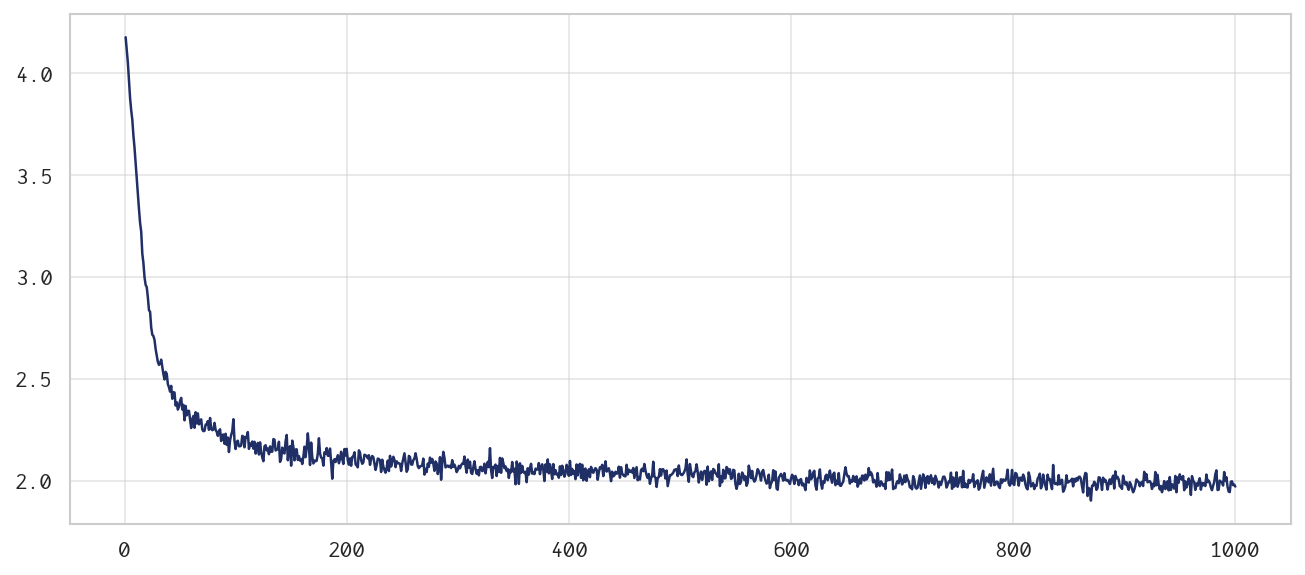

In [23]:
sns.lineplot(epochs, hist.history['loss'])
plt.show()

In [24]:
tf.keras.models.save_model(model, "./outputs/my_embedding.h5", save_format='h5')

# Word Vector

In [25]:
weight_layer0 = model.layers[0].get_weights()

In [26]:
weight_layer0[0].shape

(65, 8)

In [27]:
weight_layer0[1].shape

(8,)

In [28]:
word_vectors = weight_layer0[0] + weight_layer0[1] 

In [29]:
word_vectors.shape

(65, 8)

In [30]:
word_vectors[0]

array([ 0.24090269,  0.50388175,  0.20009199, -0.2374739 , -0.21176487,
        0.42122588, -0.13323689, -0.15874082], dtype=float32)

In [31]:
vec_df = pd.DataFrame(word_vectors)
vec_df.to_csv("./outputs/vecs.csv", index=False)
word_df = pd.DataFrame(word_index.keys())
word_df.to_csv("./outputs/word_lookup.csv", index=False)

In [32]:
# vec_df.to_csv("./outputs/vecs.tsv", sep='\t', index=False, header=False)
# word_df.to_csv("./outputs/word_lookup.tsv", sep='\t', index=False, header=False)